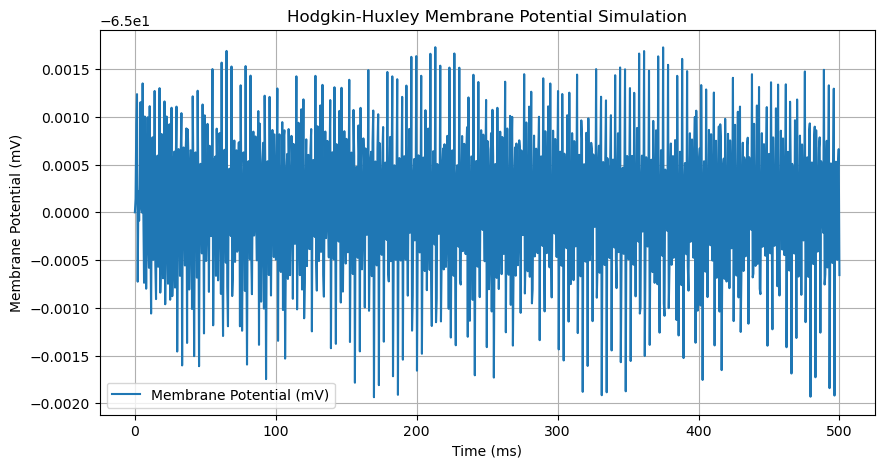

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

C_m = 1.0  
E_Na = 50.0 
E_K = -77.0 
E_L = -54.4 
G_Na = 120.0 
G_K = 36.0  
G_L = 0.3

# Hodgkin-Huxley gating variables
def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1 / (1 + np.exp(-(V + 35) / 10))

# Membrane equation
def dVm_dt(t, y):
    V, n, m, h = y
    
    dn_dt = alpha_n(V) * (1 - n) - beta_n(V) * n
    dm_dt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dh_dt = alpha_h(V) * (1 - h) - beta_h(V) * h

    I_Na = G_Na * (m**3) * h * (V - E_Na)
    I_K = G_K * (n**4) * (V - E_K)
    I_L = G_L * (V - E_L)

    dV_dt = -(I_Na + I_K + I_L) / C_m
    
    return [dV_dt, dn_dt, dm_dt, dh_dt]

# Initial conditions
V0 = -65.0 
# V0 = 0
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
y0 = [V0, n0, m0, h0]

# Time span
t_span = (0, 500)  # ms
t_eval = np.linspace(0, 500, 1000)

sol = solve_ivp(dVm_dt, t_span, y0, t_eval=t_eval, method='RK45')

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Membrane Potential (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Hodgkin-Huxley Membrane Potential Simulation')
plt.legend()
plt.grid()
plt.show()

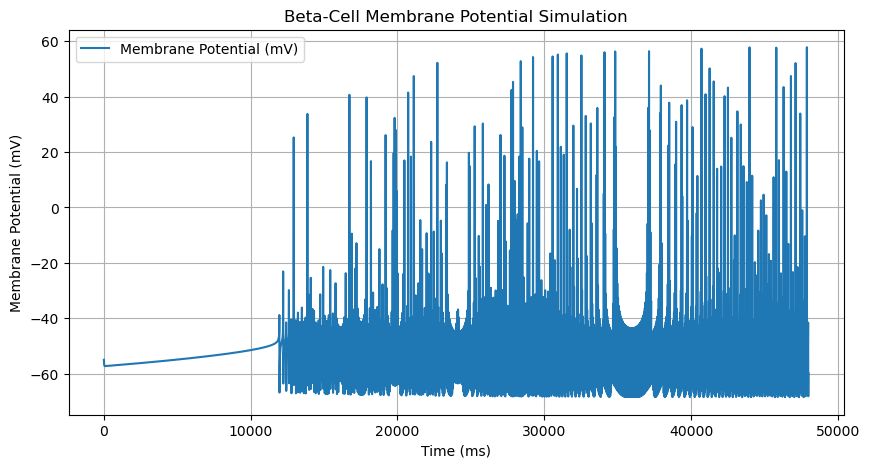

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

C_m = 1.0  # Membrane capacitance (uF/cm^2)
E_Ca = 100.0  # Calcium Nernst potential (mV)
E_K = -75.0  # Potassium Nernst potential (mV)
E_L = -40.0  # Leak Nernst potential (mV)
G_Ca = 6.5  # Maximum calcium conductance (mS/cm^2)
G_K = 12  # Maximum potassium conductance (mS/cm^2)
G_K_Ca = 0.09  # Calcium-activated potassium conductance (mS/cm^2)
G_L = 0.04  # Leak conductance (mS/cm^2)

k_Ca = 0.02 
K_disc = 1
r = 8.9
# r = 0.00089 #in cm instead of micrometers
f = 0.004
F = 96485.3321 #Faraday's constant

V_star = 30
V_line = 50

# Gating variables
def alpha_n(V):
    return 0.01 * (10 - (V + V_star)) / (np.exp((10 - (V + V_star)) / 10) - 1)

def beta_n(V):
    return 0.125 * np.exp(-(V + V_star) / 80)

def alpha_m(V):
    return 0.1 * (25 - (V + V_line)) / (np.exp((25 - (V + V_line)) / 10) - 1)

def beta_m(V):
    return 4.0 * np.exp(-(V + V_line) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + V_line) / 20)

def beta_h(V):
    return 1 / (1 + np.exp((30 - (V + V_line)) / 10))

# (Hill function)
def g_K_Ca(Ca_i):
    return G_K_Ca * (Ca_i / (Ca_i + 1))

# Membrane equation
def dVm_dt(t, y):
    V, n, m, h, Ca_i = y
    
    # Compute gating variables
    dn_dt = alpha_n(V) * (1 - n) - beta_n(V) * n
    dm_dt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dh_dt = alpha_h(V) * (1 - h) - beta_h(V) * h
    
    # Compute ionic currents
    I_Ca = G_Ca * (m**3) * h * (V - E_Ca)
    I_K = (G_K * (n**4) + g_K_Ca(Ca_i)) * (V - E_K)
    I_L = G_L * (V - E_L)
    
    # Calcium dynamics
    # dCa_i_dt = f * (-I_Ca / (2 * C_m)) - k_Ca * Ca_i
    dCa_i_dt = f * ( (3 * I_Ca / (r * F)) - k_Ca * Ca_i)
    
    # Membrane potential equation
    dV_dt = -(2*I_Ca + I_K + I_L) / C_m
    
    return [dV_dt, dn_dt, dm_dt, dh_dt, dCa_i_dt]

# Initial conditions
V0 = -55.0  # Initial membrane potential (mV)
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
Ca_i0 = 0.8  # Initial intracellular calcium concentration (arbitrary units)
y0 = [V0, n0, m0, h0, Ca_i0]

# Time span
t_span = (0, 48000)  # ms
t_eval = np.linspace(0, 48000, 5000)

# Solve ODEs
sol = solve_ivp(dVm_dt, t_span, y0, t_eval=t_eval, method='Radau')

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Membrane Potential (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Beta-Cell Membrane Potential Simulation')
plt.legend()
plt.grid()
plt.show()

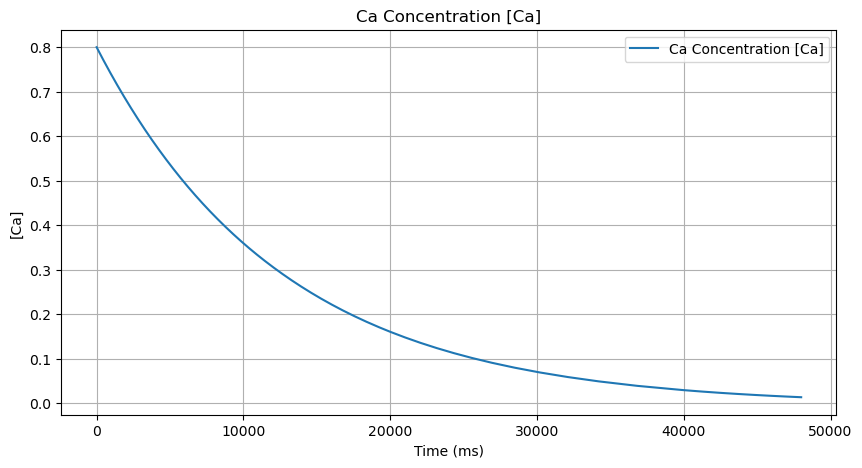

In [171]:
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[4], label='Ca Concentration [Ca]')
plt.xlabel('Time (ms)')
plt.ylabel('[Ca]')
plt.title('Ca Concentration [Ca]')
plt.legend()
plt.grid()
plt.show()

## Model #37

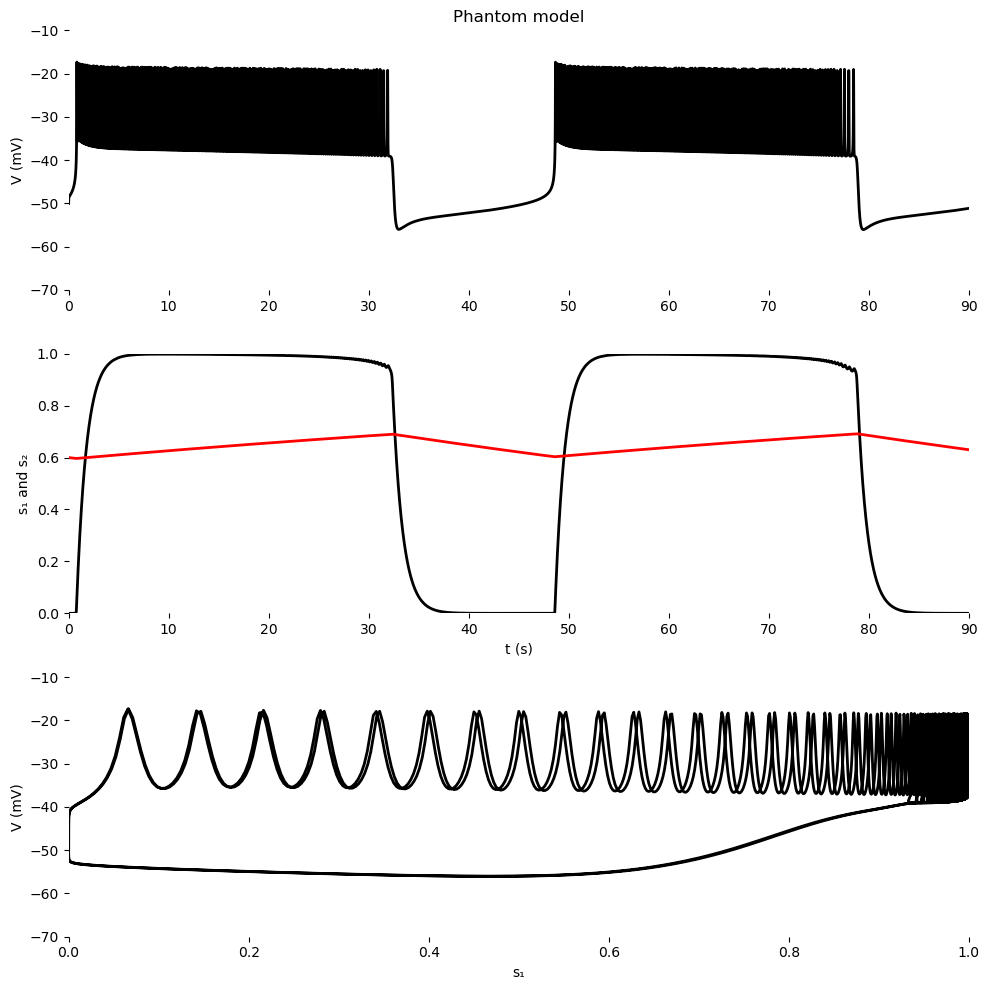

In [15]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def phantom_model(t, x, gs1=5):
    # Parameters most likely to vary
    gs2 = 32
    autos1 = 1
    autos2 = 1

    # Other parameters
    taus1 = 1000
    taus2 = 120000
    tnbar = 9.09
    vs1 = -40
    vs2 = -42
    ss1 = 0.5
    ss2 = 0.4
    s1knot = 1
    s2knot = 1
    gl = 25
    vl = -40
    gk = 1300
    vk = -80
    gca = 280
    vca = 100
    lambda_ = 1.1
    cm = 4524
    vm = -22
    sm = 7.5
    vn = -9
    sn = 10

    # Unpack variables
    v, n, s1, s2 = x

    # Gating variables
    minf = 1.0 / (1.0 + np.exp((vm - v) / sm))
    ninf = 1.0 / (1.0 + np.exp((vn - v) / sn))
    taun = tnbar / (1.0 + np.exp((v - vn) / sn))
    s1inf = 1.0 / (1.0 + np.exp((vs1 - v) / ss1))
    s2inf = 1.0 / (1.0 + np.exp((vs2 - v) / ss2))

    # Ionic currents
    ica = gca * minf * (v - vca)
    ik = gk * n * (v - vk)
    il = gl * (v - vl)
    is1 = gs1 * s1 * (v - vk) #K_ATP
    is2 = gs2 * s2 * (v - vk) #

    vdot = -(ica + ik + il + is1 + is2) / cm
    ndot = lambda_ * (ninf - n) / taun
    s1dot = (s1inf - s1) / taus1
    s2dot = (s2inf - s2) / taus2

    return [vdot, ndot, s1dot, s2dot]

def call_phantom(gs1=5, v0=0.0, tmax=90000):
    tspan = (0, tmax)
    x0 = [-50, 0, 0.0, v0]

    sol = solve_ivp(lambda t, x: phantom_model(t, x, gs1), tspan, x0, method='RK45', max_step=5.0)
    
    tsec = sol.t / 1000 
    v, n, s1, s2 = sol.y

    plt.figure(figsize=(10, 10))

    # Top panel
    plt.subplot(3, 1, 1)
    plt.plot(tsec, v, color='black', linewidth=2)
    plt.axis([0, tsec[-1], -70, -10])
    plt.title('Phantom model')
    plt.ylabel('V (mV)')
    plt.box(False)

    # Middle panel
    plt.subplot(3, 1, 2)
    plt.plot(tsec, s1, color='black', linewidth=2, label='s1')
    plt.plot(tsec, s2, color='red', linewidth=2, label='s2')
    plt.axis([0, tsec[-1], 0, 1])
    plt.xlabel('t (s)')
    plt.ylabel('s₁ and s₂')
    plt.box(False)

    # Bottom panel
    plt.subplot(3, 1, 3)
    plt.plot(s1, v, color='black', linewidth=2)
    plt.axis([0, 1, -70, -10])
    plt.xlabel('s₁')
    plt.ylabel('V (mV)')
    plt.box(False)

    plt.tight_layout()
    plt.show()

    # # Write to file
    # output = np.vstack((tsec, v, n, s1, s2)).T
    # np.savetxt("data.dat", output, fmt='%9.5f', header='t(s) v n s1 s2')

# Example usage (you can modify gs1, v0, tmax as in Figs 2–4)
call_phantom(gs1=5, v0=0.6, tmax=90000)

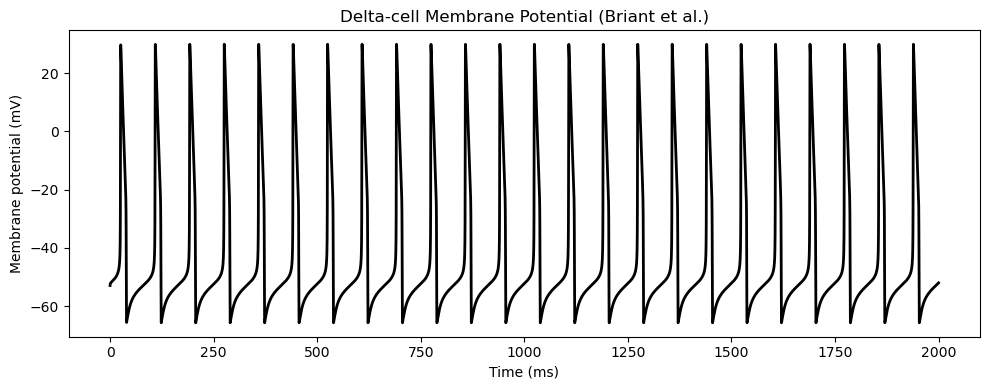

In [21]:
# Delta-cell Model (Converted from Briant et al., Figure 7)

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
params = {
    'gkatp': 0.01, 'gna': 11, 'gka': 1.2, 'gkdr': 4.5,
    'vna': 60, 'vk': -75, 'vca': 65, 'vl': -40, 'cm': 4e-3,
    'gcal': 0.65, 'gcat': 0.05, 'gcan': 0.3, 'gl': 0.1,
    'vcalm': -30, 'scalm': 10, 'vcalh': -33, 'scalh': -5,
    'tcalh1': 60, 'tcalh2': 51, 'vcatm': -49, 'scatm': 4,
    'vcath': -52, 'scath': -5, 'tcatm1': 15, 'tcatm2': 0,
    'tcath1': 20, 'tcath2': 5, 'vcanm': -5, 'scanm': 10,
    'vcanh': -33, 'scanh': -5, 'tcanh1': 2, 'tcanh2': 2,
    'vnam': -30, 'vnah': -52, 'snam': 4, 'snah': -8,
    'tnah1': 120, 'tnah2': 0.5, 'vkam': -45, 'skam': 10,
    'vkah': -68, 'skah': -10, 'taukam': 0.1, 'tkah1': 60,
    'tkah2': 5, 'taukm': 1, 'vkdrm': -25, 'skdrm': 23,
    'V2m': -28.8749674, 'sm': -5.45289598, 'V2h': -45.388663,
    'sh': 4.99005762, 'a1taum': 0.0001072, 'b1taum': 12,
    'c1taum': 40, 'a2taum': 0.000152, 'b2taum': -20,
    'c2taum': 22.69, 'a1tauh': 0.0001636, 'b1tauh': -15,
    'c1tauh': 8.6856, 'a2tauh': 0.0001857, 'b2tauh': 5,
    'c2tauh': 35.35
}

# Initial conditions
init = {
    'v': -52.91, 'mcal': 0.092, 'hcal': 0.857, 'mcat': 0.27,
    'hcat': 0.534, 'mcan': 0.008, 'hcan': 0.857, 'mna': 0.003,
    'hna': 0.339, 'mka': 0.312, 'hka': 0.182, 'mkdr': 0.237
}

# Model equations
def delta_cell_model(t, y):
    v, mcal, hcal, mcat, hcat, mcan, hcan, mna, hna, mka, hka, mkdr = y
    p = params

    # Steady states and time constants
    mcalinf = 1/(1 + np.exp(-(v - p['vcalm']) / p['scalm']))
    hcalinf = 1/(1 + np.exp(-(v - p['vcalh']) / p['scalh']))
    taucalm = (1/(np.exp(-(v+23)/20) + np.exp((v+23)/20))) + 0.05
    taucalh = (p['tcalh1']/(np.exp(-v/20) + np.exp(v/20))) + p['tcalh2']

    mcatinf = 1/(1 + np.exp(-(v - p['vcatm']) / p['scatm']))
    hcatinf = 1/(1 + np.exp(-(v - p['vcath']) / p['scath']))
    taucatm = (p['tcatm1']/(np.exp(-(v+50)/12) + np.exp((v+50)/12))) + p['tcatm2']
    taucath = (p['tcath1']/(np.exp(-(v+50)/15) + np.exp((v+50)/15))) + p['tcath2']

    mcaninf = 1/(1 + np.exp(-(v - p['vcanm']) / p['scanm']))
    hcaninf = 1/(1 + np.exp(-(v - p['vcanh']) / p['scanh']))
    taucanm = (1/(np.exp(-(v+23)/20) + np.exp((v+23)/20))) + 0.05
    taucanh = (p['tcanh1']/(np.exp(-v/20) + np.exp(v/20))) + p['tcanh2']

    mnainf = 1/(1 + np.exp((v - p['V2m']) / p['sm']))
    hnainf = 1/(1 + np.exp((v - p['V2h']) / p['sh']))
    taunam = 1e3 * (p['a1taum'] * np.exp(-((v - p['b1taum']) / p['c1taum'])**2) +
                   p['a2taum'] * np.exp(-((v - p['b2taum']) / p['c2taum'])**2))
    taunah = 1e3 * (p['a1tauh'] * np.exp(-((v - p['b1tauh']) / p['c1tauh'])**2) +
                   p['a2tauh'] * np.exp(-((v - p['b2tauh']) / p['c2tauh'])**2))

    mkainf = 1/(1 + np.exp(-(v - p['vkam']) / p['skam']))
    hkainf = 1/(1 + np.exp(-(v - p['vkah']) / p['skah']))
    taukah = (p['tkah1']/(np.exp(-(v-5)/20) + np.exp((v-5)/20))) + p['tkah2']

    mkdrinf = 1/(1 + np.exp(-(v - p['vkdrm']) / p['skdrm']))
    taukdrm = p['taukm'] * ((1.5/(np.exp(-(v+10)/25) + np.exp((v+10)/25))) + 15)

    Ical = p['gcal'] * mcal**2 * hcal * (v - p['vca'])
    Icat = p['gcat'] * mcat**3 * hcat * (v - p['vca'])
    Ican = p['gcan'] * mcan * hcan * (v - p['vca'])
    Ina = p['gna'] * mna**5 * hna * (v - p['vna'])
    Ika = p['gka'] * mka * hka * (v - p['vk'])
    Ikdr = p['gkdr'] * mkdr**4 * (v - p['vk'])
    Ikatp = p['gkatp'] * (v - p['vk'])
    Il = p['gl'] * (v - p['vl'])

    dv = -(Ical + Icat + Ican + Ina + Ikdr + Ikatp + Ika + Il) / p['cm']
    dmcal = (mcalinf - mcal) / (1 * taucalm)
    dhcal = (hcalinf - hcal) / (1 * taucalh)
    dmcat = (mcatinf - mcat) / (1 * taucatm)
    dhcat = (hcatinf - hcat) / (1 * taucath)
    dmcan = (mcaninf - mcan) / (1 * taucanm)
    dhcan = (hcaninf - hcan) / (1 * taucanh)
    dmna = (mnainf - mna) / taunam
    dhna = (hnainf - hna) / taunah
    dmka = (mkainf - mka) / p['taukam']
    dhka = (hkainf - hka) / taukah
    dmkdr = (mkdrinf - mkdr) / taukdrm

    return [dv, dmcal, dhcal, dmcat, dhcat, dmcan, dhcan, dmna, dhna, dmka, dhka, dmkdr]

# Initial conditions vector
y0 = [init[k] for k in ['v', 'mcal', 'hcal', 'mcat', 'hcat', 'mcan', 'hcan', 'mna', 'hna', 'mka', 'hka', 'mkdr']]

# Solve ODE
t_span = (0, 2000)
sol = solve_ivp(delta_cell_model, t_span, y0, method='LSODA', t_eval=np.linspace(*t_span, 20000), rtol=1e-10, atol=1e-10)

plt.figure(figsize=(10, 4))
plt.plot(sol.t, sol.y[0], color='black', linewidth=2, label='V (membrane potential)')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Delta-cell Membrane Potential (Briant et al.)')
plt.grid(False)
plt.tight_layout()
plt.show()

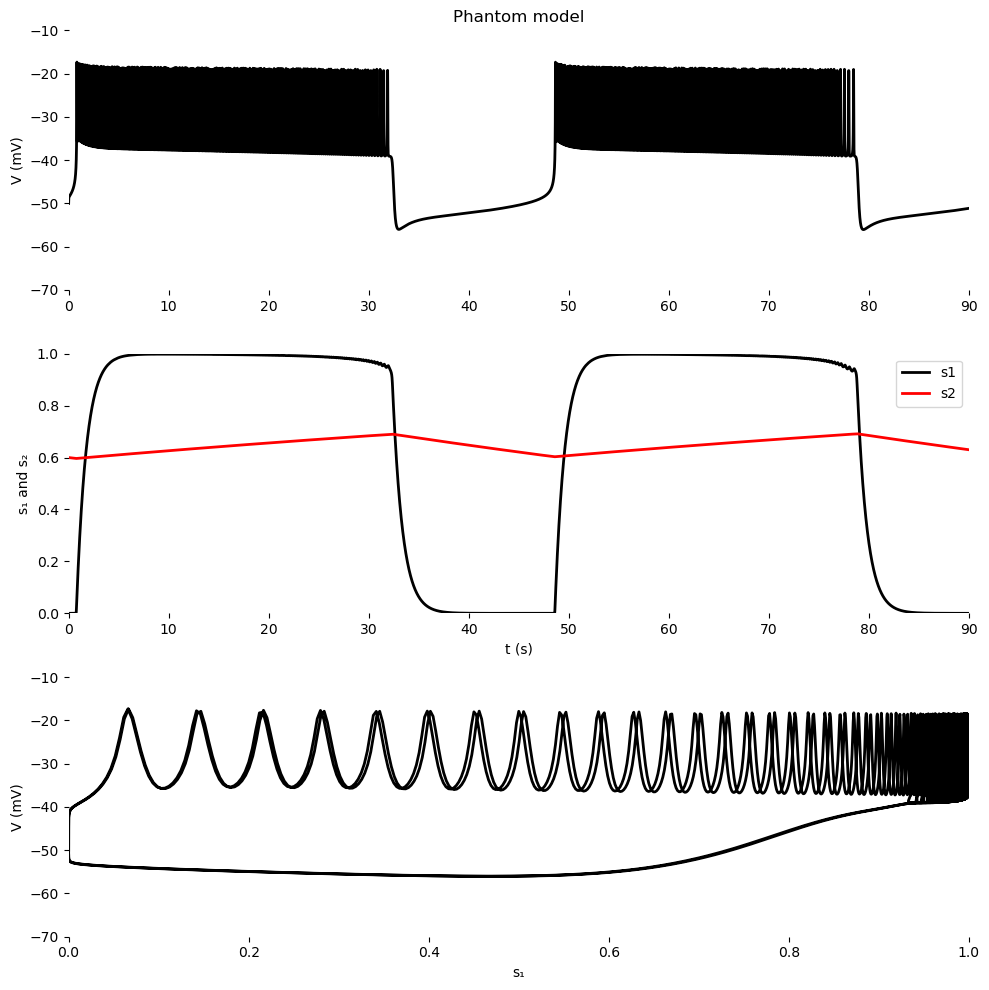

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


class SingleBetaCell:
    def __init__(
        self,
        gs1=5,
        gs2=32,
        taus1=1000,
        taus2=120000,
        tnbar=9.09,
        vs1=-40,
        vs2=-42,
        ss1=0.5,
        ss2=0.4,
        s1knot=1,
        s2knot=1,
        gl=25,
        vl=-40,
        gk=1300,
        vk=-80,
        gca=280,
        vca=100,
        lambda_=1.1,
        cm=4524,
        vm=-22,
        sm=7.5,
        vn=-9,
        sn=10,
    ):
        # Store all parameters as instance variables
        self.gs1 = gs1
        self.gs2 = gs2
        self.taus1 = taus1
        self.taus2 = taus2
        self.tnbar = tnbar
        self.vs1 = vs1
        self.vs2 = vs2
        self.ss1 = ss1
        self.ss2 = ss2
        self.s1knot = s1knot
        self.s2knot = s2knot
        self.gl = gl
        self.vl = vl
        self.gk = gk
        self.vk = vk
        self.gca = gca
        self.vca = vca
        self.lambda_ = lambda_
        self.cm = cm
        self.vm = vm
        self.sm = sm
        self.vn = vn
        self.sn = sn

    def dynamics(self, t, x):
        """Calculate the dynamics of the beta cell model"""
        # Unpack variables
        v, n, s1, s2 = x

        # Gating variables
        minf = 1.0 / (1.0 + np.exp((self.vm - v) / self.sm))
        ninf = 1.0 / (1.0 + np.exp((self.vn - v) / self.sn))
        taun = self.tnbar / (1.0 + np.exp((v - self.vn) / self.sn))
        s1inf = 1.0 / (1.0 + np.exp((self.vs1 - v) / self.ss1))
        s2inf = 1.0 / (1.0 + np.exp((self.vs2 - v) / self.ss2))

        # Ionic currents
        ica = self.gca * minf * (v - self.vca)
        ik = self.gk * n * (v - self.vk)
        il = self.gl * (v - self.vl)
        is1 = self.gs1 * s1 * (v - self.vk)
        is2 = self.gs2 * s2 * (v - self.vk)

        # Differential equations
        vdot = -(ica + ik + il + is1 + is2) / self.cm
        ndot = self.lambda_ * (ninf - n) / taun
        s1dot = (s1inf - s1) / self.taus1
        s2dot = (s2inf - s2) / self.taus2

        return np.array([vdot, ndot, s1dot, s2dot])

    def simulate(self, v0=0.0, n0=0.0, s10=0.0, s20=0.6, tmax=90000, max_step=5.0):
        """Simulate the beta cell model"""
        tspan = (0, tmax)
        x0 = [-50, n0, s10, s20]

        # Solve ODE
        sol = solve_ivp(self.dynamics, tspan, x0, method="RK45", max_step=max_step)

        return sol

    def plot_results(self, sol):
        """Plot the simulation results"""
        tsec = sol.t / 1000  # convert ms to seconds
        v, n, s1, s2 = sol.y

        plt.figure(figsize=(10, 10))

        # Top panel
        plt.subplot(3, 1, 1)
        plt.plot(tsec, v, color="black", linewidth=2)
        plt.axis([0, tsec[-1], -70, -10])
        plt.title("Phantom model")
        plt.ylabel("V (mV)")
        plt.box(False)

        # Middle panel
        plt.subplot(3, 1, 2)
        plt.plot(tsec, s1, color="black", linewidth=2, label="s1")
        plt.plot(tsec, s2, color="red", linewidth=2, label="s2")
        plt.axis([0, tsec[-1], 0, 1])
        plt.xlabel("t (s)")
        plt.ylabel("s₁ and s₂")
        plt.legend()
        plt.box(False)

        # Bottom panel
        plt.subplot(3, 1, 3)
        plt.plot(s1, v, color="black", linewidth=2)
        plt.axis([0, 1, -70, -10])
        plt.xlabel("s₁")
        plt.ylabel("V (mV)")
        plt.box(False)

        plt.tight_layout()
        plt.show()

    def run_simulation(self, gs1=5, v0=0.6, tmax=90000):
        """Run a simulation with the given parameters and plot the results"""
        # Update gs1 if needed
        self.gs1 = gs1

        # Run simulation
        sol = self.simulate(s20=v0, tmax=tmax)

        # Plot results
        self.plot_results(sol)

        return sol

    def save_data(self, sol, filename="data.dat"):
        """Save simulation results to a file"""
        tsec = sol.t / 1000  # convert ms to seconds
        v, n, s1, s2 = sol.y
        output = np.vstack((tsec, v, n, s1, s2)).T
        np.savetxt(filename, output, fmt="%9.5f", header="t(s) v n s1 s2")


def main():
    # Create instance of SingleBetaCell with default parameters
    model = SingleBetaCell()

    # Example usage (you can modify gs1, v0, tmax as in Figs 2–4)
    model.run_simulation(gs1=5, v0=0.6, tmax=90000)

if __name__ == "__main__":
    # Run the main function
    main()

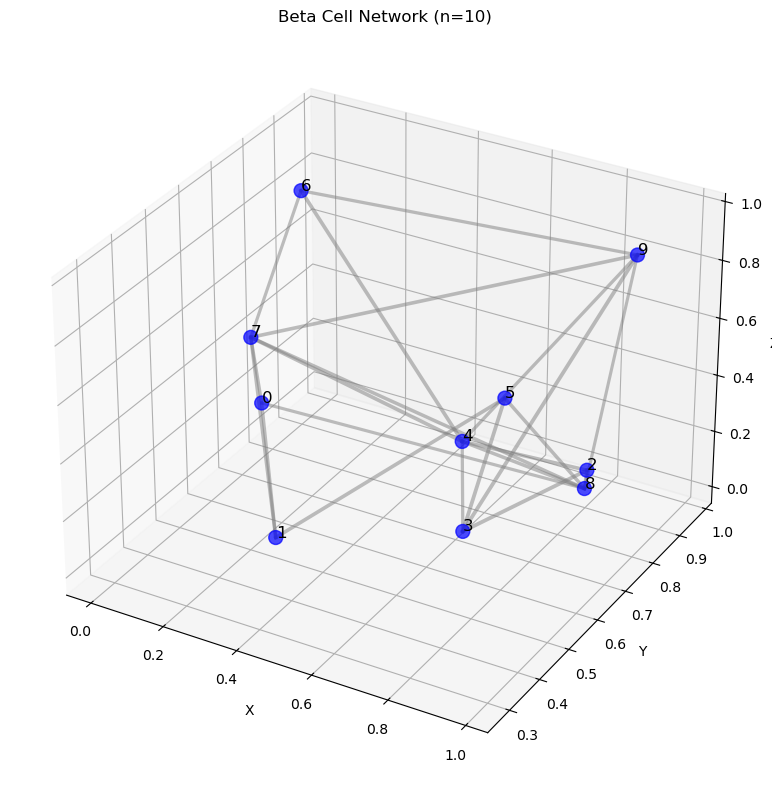

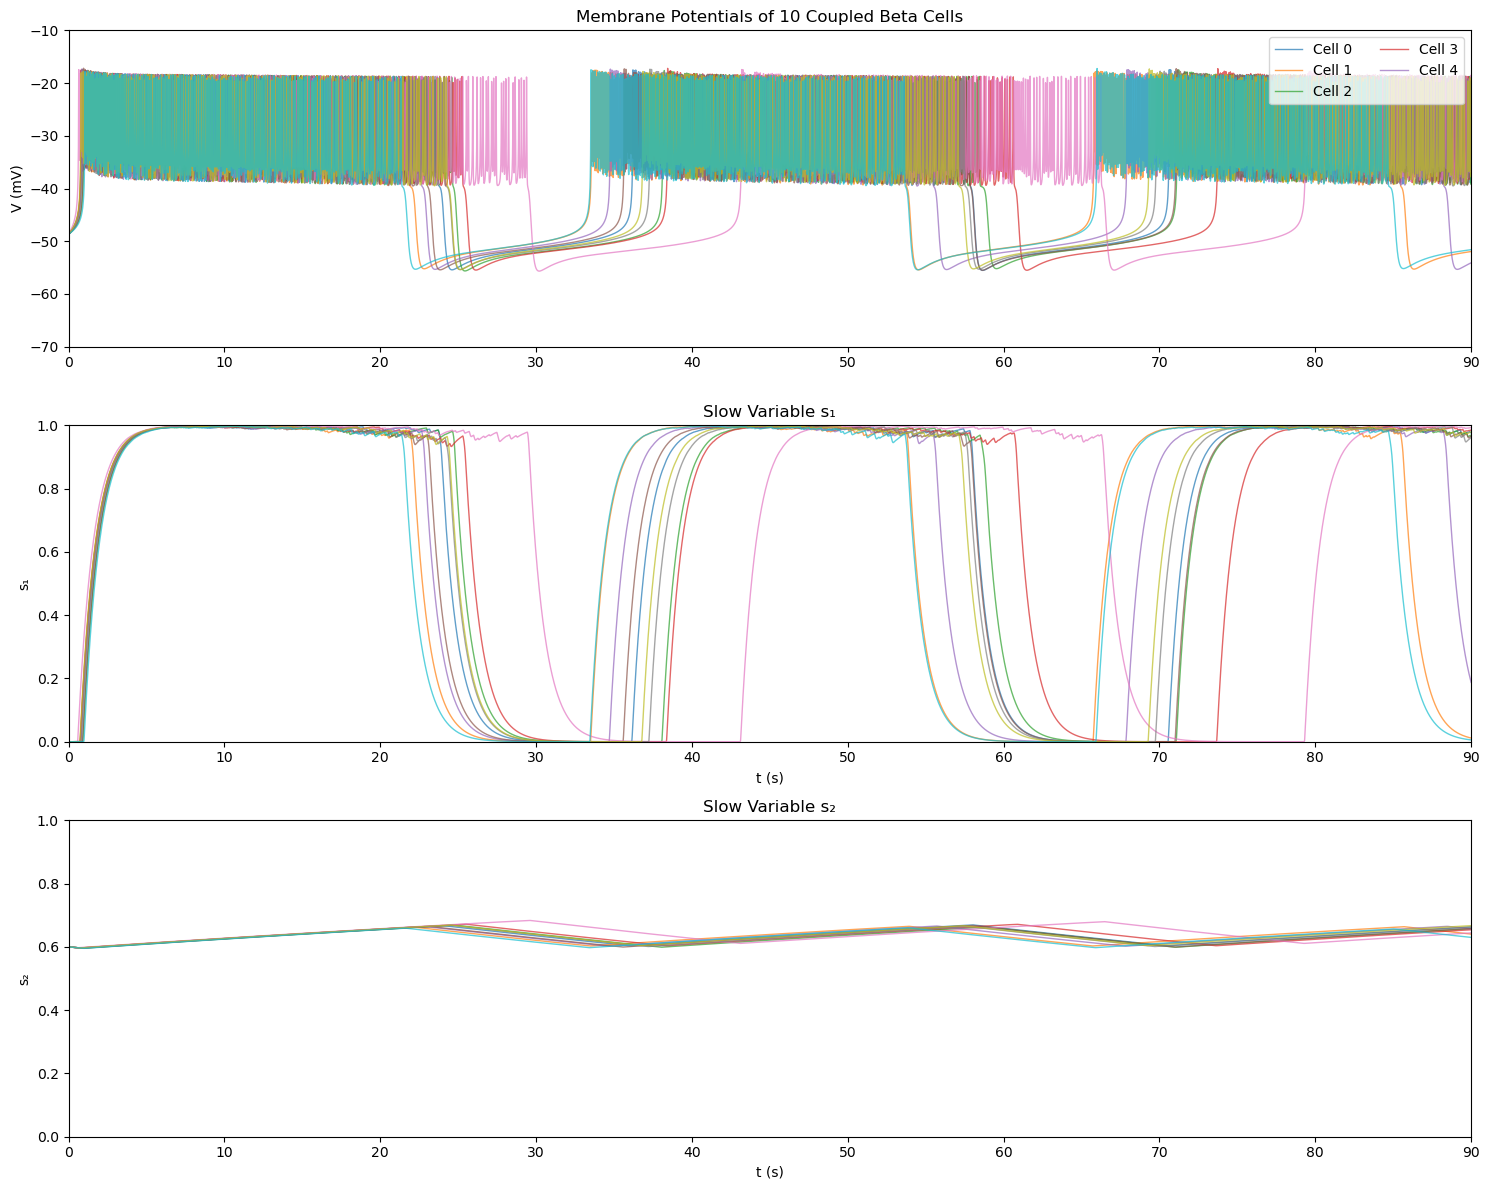

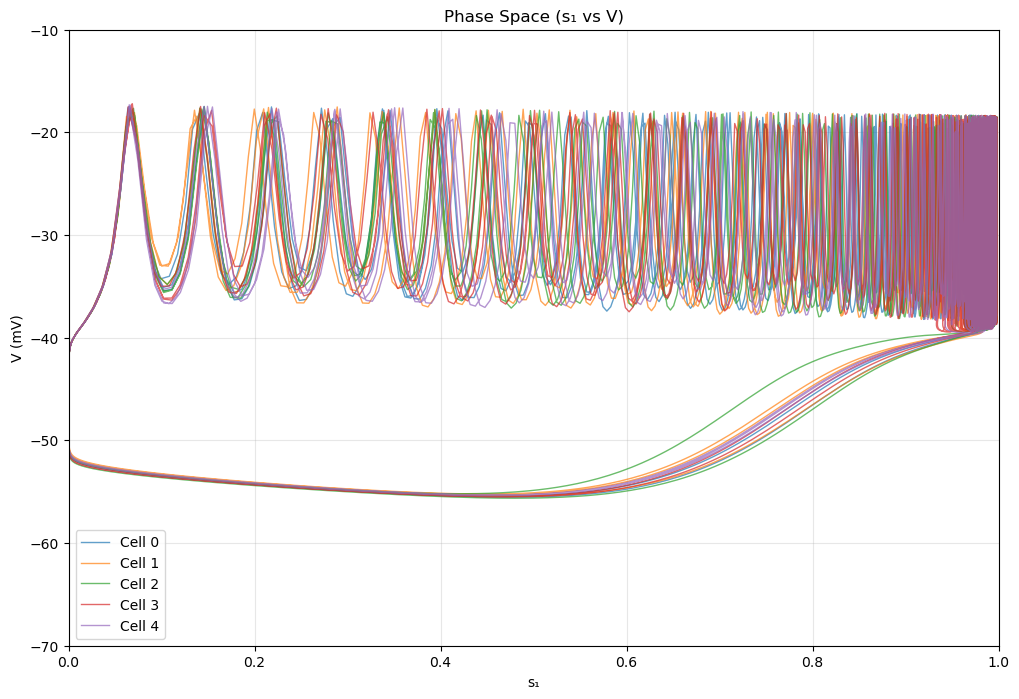

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go

class BetaCellNetwork:
    def __init__(
        self, num_cells=10, mean_gj=40, std_gj=1, min_connections=1, max_connections=5
    ):
        """
        Initialize a network of coupled beta cells

        Parameters:
        -----------
        num_cells : int
            Number of beta cells in the network
        mean_gj : float
            Mean gap junction conductance in pS
        std_gj : float
            Standard deviation of gap junction conductance in pS
        min_connections : int
            Minimum number of connections per cell
        max_connections : int
            Maximum number of connections per cell
        """
        self.num_cells = num_cells
        self.mean_gj = mean_gj  # pS
        self.std_gj = std_gj  # pS
        self.min_connections = min_connections
        self.max_connections = max_connections

        # Create individual beta cells with slightly varied parameters
        self.cells = []
        for i in range(num_cells):
            # Add slight variation to parameters
            # gs1 = np.random.normal(5, 0.2)
            # gs2 = np.random.normal(32, 1.0)
            gs1 = np.random.normal(5, 0.05)
            gs2 = np.random.normal(32, 0.2)
            self.cells.append(SingleBetaCell(gs1=gs1, gs2=gs2))

        # Create connectivity matrix (adjacency matrix with weights)
        self.create_network()

    def create_network(self):
        """Create network connectivity with gap junctions"""
        # Initialize adjacency matrix with zeros
        self.adjacency_matrix = np.zeros((self.num_cells, self.num_cells))

        # Create a graph for visualization
        self.graph = nx.Graph()
        self.graph.add_nodes_from(range(self.num_cells))

        # Assign 3D positions for visualization
        self.positions = {}
        for i in range(self.num_cells):
            # Randomly position cells in 3D space
            self.positions[i] = (np.random.rand(), np.random.rand(), np.random.rand())

        # For each cell, determine connections
        for i in range(self.num_cells):
            # Determine number of connections for this cell
            num_connections = np.random.randint(
                self.min_connections, self.max_connections + 1
            )

            # Find cells that are not yet connected to cell i
            possible_connections = [
                j
                for j in range(self.num_cells)
                if j != i and self.adjacency_matrix[i, j] == 0
            ]

            # If we have fewer possible connections than needed, use all available
            num_connections = min(num_connections, len(possible_connections))

            # Choose random cells to connect with
            if possible_connections:
                # Calculate distances between cell i and all other cells
                distances = {}
                for j in possible_connections:
                    pos_i = self.positions[i]
                    pos_j = self.positions[j]
                    dist = np.sqrt(
                        (pos_i[0] - pos_j[0]) ** 2
                        + (pos_i[1] - pos_j[1]) ** 2
                        + (pos_i[2] - pos_j[2]) ** 2
                    )
                    distances[j] = dist

                # Sort by distance and prefer closer cells (with some randomness)
                sorted_cells = sorted(distances.items(), key=lambda x: x[1])
                preferred_cells = [
                    cell for cell, _ in sorted_cells[: num_connections * 2]
                ]

                if len(preferred_cells) > num_connections:
                    connected_cells = np.random.choice(
                        preferred_cells, num_connections, replace=False
                    )
                else:
                    connected_cells = preferred_cells

                # Create connections with random gap junction conductances
                for j in connected_cells:
                    # Generate a random conductance from normal distribution
                    conductance = np.random.normal(self.mean_gj, self.std_gj)
                    conductance = max(1, conductance)  # Ensure positive conductance

                    # Set the adjacency matrix (symmetric)
                    self.adjacency_matrix[i, j] = conductance
                    self.adjacency_matrix[j, i] = conductance

                    # Add edge to graph
                    self.graph.add_edge(i, j, weight=conductance)

    def dynamics(self, t, x):
        """
        Coupled dynamics of all cells in the network

        Parameters:
        -----------
        t : float
            Current time
        x : array
            State variables for all cells: [v1, n1, s11, s21, v2, n2, s12, s22, ...]

        Returns:
        --------
        dxdt : array
            Derivatives of state variables
        """
        # Reshape to get state for each cell
        x_reshaped = x.reshape(self.num_cells, 4)

        # Initialize the derivative array
        dxdt = np.zeros_like(x_reshaped)

        # Calculate intrinsic dynamics for each cell
        for i in range(self.num_cells):
            dxdt[i] = self.cells[i].dynamics(t, x_reshaped[i])

        # Add gap junction currents to voltage derivatives
        for i in range(self.num_cells):
            v_i = x_reshaped[i, 0]  # Voltage of cell i

            # Sum up gap junction currents
            gj_current = 0
            for j in range(self.num_cells):
                if self.adjacency_matrix[i, j] > 0:
                    v_j = x_reshaped[j, 0]  # Voltage of cell j
                    gj = self.adjacency_matrix[i, j] * 1e-12  # Convert pS to S
                    gj_current += gj * (v_j - v_i)

            # Add gap junction current to voltage derivative (I = g*dV)
            dxdt[i, 0] += gj_current / self.cells[i].cm

        # Return flattened array
        return dxdt.flatten()

    def simulate(self, tmax=90000, max_step=10.0):
        """
        Simulate the network of coupled beta cells

        Parameters:
        -----------
        tmax : float
            Maximum simulation time in ms
        max_step : float
            Maximum step size for solver

        Returns:
        --------
        sol : OdeSolution
            Solution object from solve_ivp
        """
        tspan = (0, tmax)

        # Initialize states with slight variation
        x0 = np.zeros(self.num_cells * 4)
        for i in range(self.num_cells):
            # Voltage slight variation
            # x0[i * 4] = -50 + np.random.normal(0, 0.1)
            x0[i * 4] = -50
            # n initialized to 0
            x0[i * 4 + 1] = 0.0
            # s1 initialized to 0
            x0[i * 4 + 2] = 0.0
            # s2 slight variation around v0
            # x0[i * 4 + 3] = 0.6 + np.random.normal(0, 0.05)
            x0[i * 4 + 3] = 0.6


        # Solve the system
        sol = solve_ivp(self.dynamics, tspan, x0, method="RK45", max_step=max_step)

        return sol

    def plot_network(self):
        """Visualize the network connectivity"""
        plt.figure(figsize=(10, 8))
        ax = plt.subplot(111, projection="3d")

        # Extract 3D positions
        pos = self.positions
        xs = [pos[i][0] for i in range(self.num_cells)]
        ys = [pos[i][1] for i in range(self.num_cells)]
        zs = [pos[i][2] for i in range(self.num_cells)]

        # Plot nodes
        ax.scatter(xs, ys, zs, s=100, c="blue", alpha=0.7)

        # Plot edges
        for i, j in self.graph.edges():
            weight = self.adjacency_matrix[i, j]
            x = [pos[i][0], pos[j][0]]
            y = [pos[i][1], pos[j][1]]
            z = [pos[i][2], pos[j][2]]
            # Line width proportional to weight
            lw = 0.5 + 2.0 * weight / self.mean_gj
            ax.plot(x, y, z, "gray", alpha=0.5, linewidth=lw)

        # Add node labels
        for i in range(self.num_cells):
            ax.text(pos[i][0], pos[i][1], pos[i][2], str(i), fontsize=12)

        ax.set_title(f"Beta Cell Network (n={self.num_cells})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.tight_layout()
        plt.show()


    def plot_results(self, sol):
        """
        Plot simulation results

        Parameters:
        -----------
        sol : OdeSolution
            Solution from simulate method
        """
        # Convert time from ms to seconds
        tsec = sol.t / 1000

        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(15, 12))

        # Plot voltages
        ax1 = fig.add_subplot(3, 1, 1)
        for i in range(self.num_cells):
            v = sol.y[i * 4]
            ax1.plot(
                tsec, v, linewidth=1, alpha=0.7, label=f"Cell {i}" if i < 5 else ""
            )

        ax1.set_xlim(0, tsec[-1])
        ax1.set_ylim(-70, -10)
        ax1.set_ylabel("V (mV)")
        ax1.set_title(f"Membrane Potentials of {self.num_cells} Coupled Beta Cells")
        if self.num_cells <= 5:
            ax1.legend(loc="upper right")
        else:
            ax1.legend(loc="upper right", ncol=2)

        # Plot s1 variables
        ax2 = fig.add_subplot(3, 1, 2)
        for i in range(self.num_cells):
            s1 = sol.y[i * 4 + 2]
            ax2.plot(tsec, s1, linewidth=1, alpha=0.7)

        ax2.set_xlim(0, tsec[-1])
        ax2.set_ylim(0, 1)
        ax2.set_xlabel("t (s)")
        ax2.set_ylabel("s₁")
        ax2.set_title("Slow Variable s₁")

        # Plot s2 variables
        ax3 = fig.add_subplot(3, 1, 3)
        for i in range(self.num_cells):
            s2 = sol.y[i * 4 + 3]
            ax3.plot(tsec, s2, linewidth=1, alpha=0.7)

        ax3.set_xlim(0, tsec[-1])
        ax3.set_ylim(0, 1)
        ax3.set_xlabel("t (s)")
        ax3.set_ylabel("s₂")
        ax3.set_title("Slow Variable s₂")

        plt.tight_layout()
        plt.show()

        # Plot a phase space of s1 vs V for the first few cells
        plt.figure(figsize=(12, 8))
        for i in range(min(5, self.num_cells)):
            v = sol.y[i * 4]
            s1 = sol.y[i * 4 + 2]
            plt.plot(s1, v, linewidth=1, alpha=0.7, label=f"Cell {i}")

        plt.xlim(0, 1)
        plt.ylim(-70, -10)
        plt.xlabel("s₁")
        plt.ylabel("V (mV)")
        plt.title("Phase Space (s₁ vs V)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # def save_data(self, sol, filename="network_data.npz"):
    #     """
    #     Save simulation results to a file

    #     Parameters:
    #     -----------
    #     sol : OdeSolution
    #         Solution from simulate method
    #     filename : str
    #         Filename to save data
    #     """
    #     # Extract data
    #     t = sol.t
    #     y = sol.y

    #     # Save to npz file
    #     np.savez(
    #         filename,
    #         t=t,
    #         y=y,
    #         adjacency_matrix=self.adjacency_matrix,
    #         positions=self.positions,
    #     )

    #     print(f"Data saved to {filename}")


def main():
    # Create a network of 10 beta cells
    network = BetaCellNetwork(
        num_cells=10, mean_gj=150000, std_gj=10000, min_connections=1, max_connections=5
    )

    # Visualize the network
    network.plot_network()

    # Simulate network dynamics
    sol = network.simulate(tmax=90000)

    # Plot results
    network.plot_results(sol)
    

if __name__ == "__main__":
    main()